In [17]:
import arcpy
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from arcpy import env
from arcpy.management import *
from arcpy.conversion import *
from arcpy.da import *
from arcpy.sa import *
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from autogluon.tabular import TabularPredictor
import shutil

In [3]:
# 分析函数
# 取消并行处理
def disable_parallel_processing(func):
    def wrapper(*args, **kwargs):
        with arcpy.EnvManager(parallelProcessingFactor="0"):
            return func(*args, **kwargs)
    return wrapper
# 采样
def sample_point(point_,raster_,out_name):
    """根据栅格采样点,输出为表格"""
    Sample(raster_,point_,out_name,"NEAREST", "OBJECTID", "CURRENT_SLICE", None, '', None, None, "ROW_WISE", "TABLE")
    return None

# 导出CSV
def export_csv(table_,out_path,out_name):
    TableToTable(table_,out_path,out_name)
    return None
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster
# 数组整形
def resize_arrays(A, B, fill_value=0):
    """调整数组形状一致,A为参考数组, B为待调整数组, fill_value为填充值"""
    # new_shape = (max(A.shape[0], B.shape[0]), max(A.shape[1], B.shape[1]))
    new_shape = (A.shape[0], A.shape[1])

    if A.shape != new_shape:
        if A.shape[0] < new_shape[0]:
            padding_rows = new_shape[0] - A.shape[0]
            padding = np.full((padding_rows, A.shape[1]), fill_value)
            A = np.vstack((A, padding))
        elif A.shape[0] > new_shape[0]:
            A = A[:new_shape[0], :]

        if A.shape[1] < new_shape[1]:
            pad_width = ((0, 0), (0, new_shape[1] - A.shape[1]))
            A = np.pad(A, pad_width, mode='constant', constant_values=fill_value)
        elif A.shape[1] > new_shape[1]:
            A = A[:, :new_shape[1]]
    
    if B.shape != new_shape:
        if B.shape[0] < new_shape[0]:
            padding_rows = new_shape[0] - B.shape[0]
            padding = np.full((padding_rows, B.shape[1]), fill_value)
            B = np.vstack((B, padding))
        elif B.shape[0] > new_shape[0]:
            B = B[:new_shape[0], :]

        if B.shape[1] < new_shape[1]:
            pad_width = ((0, 0), (0, new_shape[1] - B.shape[1]))
            B = np.pad(B, pad_width, mode='constant', constant_values=fill_value)
        elif B.shape[1] > new_shape[1]:
            B = B[:, :new_shape[1]]
    
    return A, B
# rf寻找最优参数
def rf_best_param(X_train,y_train,n_estimators_range,k=5):
    """默认为5折交叉验证,评价指标为R2"""
    # 设置树的数目范围
    n_estimators_range = n_estimators_range
    cv_scores = []
    # 使用交叉验证
    for n_estimators in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        scores = cross_val_score(rf,X_train, y_train, cv=k, scoring='accuracy')  # K折交叉验证 分类问题默认使用accuracy
        cv_scores.append(scores.mean())
    # 选择最优数量的树
    optimal_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
    return optimal_n_estimators

# arcpy栅格众数滤波
@disable_parallel_processing
def mode_filter(in_raster,filter_size="FOUR",filter_method="MAJORITY"):
    """栅格众数滤波,filter_size:滤波窗口大小,filter_method:滤波方法"""
    result_raster = MajorityFilter(in_raster, filter_size, filter_method) # 默认为4邻域 众数滤波  可选为8邻域 半数滤波
    return result_raster
    
# arcpy栅格边界清理
@disable_parallel_processing
def clean_boundary(in_raster,sort_method="NO_SORT",clean_method="TWO_WAY"):
    """栅格边界清理,sort_method:排序方法,clean_method:清理方法"""
    result_raster = BoundaryClean(in_raster, "NO_SORT", "TWO_WAY") # 默认为不排序 两边清理 可选为排序 一边清理
    return result_raster
# arcpy栅格区域分组
@disable_parallel_processing
def region_group(in_raster,group_size="FOUR",method="WITHIN",add_link="ADD_LINK",clear=None):
    """栅格区域分组,group_size:分组大小,method:分组方法,add_link:添加链接,clear:排除的值"""
    result_raster = RegionGroup(in_raster, group_size, method, add_link, clear) # 默认为4邻域 分组方法为WITHIN 可选为8邻域 分组方法为CROSS
    return result_raster
# arcpy栅格按属性提取
@disable_parallel_processing
def extract_by_attributes(in_raster,where_clause="count >= 100"):
    """栅格按属性提取,where_clause:属性条件"""
    result_raster = ExtractByAttributes(in_raster, where_clause) # 默认为count >= 100
    return result_raster

# arcpy栅格Nibble
@disable_parallel_processing
def nibble(in_raster,mask_raster, nibble_mask="ALL_VALUES", nibble_values="PRESERVE_NODATA"):
    """栅格Nibble,nibble_mask:掩膜,nibble_values:填充值"""
    result_raster = Nibble(in_raster, mask_raster,nibble_mask, nibble_values) # 默认为ALL_VALUES PRESERVE_NODATA 可选为DATA_ONLY PRESERVE_DATA
    return result_raster

# arcpy栅格查找表
@disable_parallel_processing
def lookup(in_raster,lookup_field="LINK"):
    """栅格查找表,lookup_field:查找字段"""
    result_raster = Lookup(in_raster, lookup_field) # 默认为LINK
    return result_raster


In [7]:
# 地理数据库路径
base_gdb_5m = r"D:\ArcgisData\basedata\basetrain_5m.gdb"
base_gdb_30m = r"D:\ArcgisData\basedata\basetrain_30m.gdb"
# 数据点文件路径
point_data = r"D:\ArcgisData\pred_tl\pred_database\TL.gdb\SY_SOIL_POINT"
# 存储采样数据表的文件地理数据库
sample_gdb_path = r"D:\ArcgisData\pred_organic_p_n\feature_table\tableresult.gdb"
# 存储采样结果CSV文件的路径
sample_csv = r"D:\ArcgisData\pred_organic_p_n\feature_table\feature_table_result"
# 输出CSV文件的名称
sample_csv_name = "feature_table_result.csv"
# 目标标签
target_label = "土种"
# 随机森林树的范围
n_estimators_range = range(10, 3000, 300)
# rf模型存储路径
modle_save_path = r"D:\ArcgisData\pred_tl\pred_moudle\rf"
# rf模型名称
modle_name = "rf_model.pkl"
# 栅格输出标准化的数据库
stander_raster_gdb = base_gdb_5m
# 标准化待预测数据分割路径
cut_csv_path = r"D:\ArcgisData\pred_tl\pred_table\cut_csv"
# 预测完成CSV文件存储路径
pred_csv_path = r"D:\ArcgisData\pred_tl\pred_table\pre_csv"
# 完整预测数据存储路径
merge_csv_path = r"D:\ArcgisData\pred_tl\pred_table\merge_csv"
# 完整预测数据存储名称
merge_csv_name = "merge.csv"
# 栅格输出预测结果数据库
pred_raster_gdb = r"D:\ArcgisData\pred_tl\pred_database\TL_basedata.gdb"
# 栅格输出预测结果栅格名称
pred_raster_name = "TL_PRED_0817"

In [8]:
# 采样点数据名称
sample_name = 'SY_SOIL_POINT'
filed_list = [_.name for _ in arcpy.ListFields(point_data)]
print(filed_list)
elements_yes = ['OBJECTID', '亚类', '土类','土属','土种']
filter_list = [_ for _ in filed_list if _ in elements_yes]
print(filter_list)


['OBJECTID', 'Shape', '亚类', '土种', '土类', '土属']
['OBJECTID', '亚类', '土种', '土类', '土属']


In [9]:
# 指定指标
# 指标列表['TWI5','TPI201','TPI101','TPI11','TPI3','TMP','SOILQS','SLOP','PRE','NIGTH','NDVI','DEM','CUR','ASP','PLCUR','POCUR','OSJL','LAT','LON','DZ','DL','SOM','SC','PH']
feature_list = ['LAT','LON','DZ','DL','PH','SOM','SC']


In [10]:
# 使用训练点数据集采样并输出到csv文件
# 选择用于采样的数据库
env.workspace = stander_raster_gdb # 切换工作空间用于采样
# 选择用于采样的要素类
point_data = point_data
# 使用Delete_management函数删除数据库中的所有内容
try:
    arcpy.Delete_management(sample_gdb_path)
except:
    pass
# 再创建一个新的数据库
arcpy.management.CreateFileGDB(os.path.dirname(sample_gdb_path), "tableresult", "CURRENT")
# 逐个采样并保存到csv文件
for one_feature in feature_list:
    sample_point(point_data,one_feature,os.path.join(sample_gdb_path,one_feature))
env.workspace = os.path.join(sample_gdb_path) # 切换工作空间用于导出csv文件
# 读取数据表并保存到csv文件
result_df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(point_data,filter_list))
result_df.rename(columns={"OBJECTID":sample_name},inplace=True)
#  读取每个表的最后一个字段的数据,存储每个表的最后一个字段的数据
for table in feature_list:
    # 将表转换为pandas数据帧
    df = pd.DataFrame(arcpy.da.TableToNumPyArray(table, "*"))  # 确保数据表中无空值
    # 提取最后一个字段的数据
    merged_df = df[[sample_name, df.columns[-1]]]
    # 合并
    result_df = pd.merge(result_df, merged_df, on=[sample_name])
# 保存到csv文件
result_df.rename(columns=dict(zip(result_df.columns[-len(feature_list):], feature_list)),inplace=True)
result_df.drop(result_df.columns[0],axis=1,inplace=True)
result_df.to_csv(os.path.join(sample_csv,sample_csv_name),index=False)

In [76]:
# 读取CSV文件使用RF训练模型
data = pd.read_csv(os.path.join(sample_csv,sample_csv_name))
print(len(data))
# 删除有缺失值的行
data.dropna(inplace=True)
len(data),data.columns
# 处理字符串数据
le =LabelEncoder()
data[target_label] = le.fit_transform(data[target_label])
data['DL'] = le.fit_transform(data['DL'])
data['DZ'] = le.fit_transform(data['DZ'])
data['SC'] = le.fit_transform(data['SC'])

# 划分数据集
X = data[feature_list]
y = data[target_label]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=42)
# 寻找最优树的个数
# best_tree = rf_best_param(X_train,y_train,n_estimators_range,5)
best_tree = 100
print(f"最优树的个数为:{best_tree}")
# 初始化和训练随机森林模型
rf = RandomForestClassifier(n_estimators=best_tree, random_state=42,max_depth=15)
rf.fit(X_train,y_train)

1915
最优树的个数为:100


RandomForestClassifier(max_depth=15, random_state=42)

In [77]:
# 保存模型
with open(os.path.join(modle_save_path,modle_name), 'wb') as f:
    pickle.dump(rf, f)
# 加载模型
with open(os.path.join(modle_save_path,modle_name), 'rb') as f:
    predictor = pickle.load(f)
# 输出模型再测试集上的准确率,F1值,召回率,精确率
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))


0.999129677980853
0.5939947780678851


In [15]:
# 试验区域预测数据统一
env.workspace = stander_raster_gdb
# 查看数据形状的一致性
stand_shape = arcpy.RasterToNumPyArray(feature_list[0]).shape
err_list = []
for one_raster in feature_list[1:]:
    if arcpy.RasterToNumPyArray(one_raster).shape != stand_shape:
        # 将形状不同的数据输出
        print(one_raster)
        # 重新设置数据形状
        err_list.append(one_raster)
# 构造数据
feature_array_list = []
for one_raster in feature_list:
    if one_raster in err_list:
        # 跳过形状不同的数据
        one_array=resize_arrays(arcpy.RasterToNumPyArray(feature_list[0]),arcpy.RasterToNumPyArray(one_raster), 0)[1]
    else:
        # 读取数据
        one_array = arcpy.RasterToNumPyArray(one_raster)
    # 将数据转换为一维数组
    one_array = one_array.flatten()
    # 将数据添加到列表中
    feature_array_list.append(one_array)
# 将列表转换为数组
feature_array_list = np.column_stack(feature_array_list)

DL
SOM
SC


In [16]:
# 将数组转换为数据帧
feature_df = pd.DataFrame(feature_array_list,columns=feature_list)
# 修改部分列的数据类型
feature_df['DL'] = feature_df['DL'].astype('str')
feature_df['DZ'] = feature_df['DZ'].astype('str')
feature_df['SC'] = feature_df['SC'].astype('str')

In [ ]:
# 分割数据并保存为csv文件
#清空文件夹内的所有文件
shutil.rmtree(cut_csv_path)
# 创建文件夹
os.mkdir(cut_csv_path)
chunk_size = 100000  # 每个文件的行数
total_rows = feature_df.shape[0]
for i in range(0, total_rows, chunk_size):
    start = i
    end = min(i + chunk_size, total_rows)
    filename =  os.path.join(cut_csv_path,f'data_chunk_{i}.csv') # 文件名格式可以根据您的需要进行修改
    df_chunk = feature_df.iloc[start:end]
    df_chunk.to_csv(filename, index=False)
    print(i,end=',')

In [78]:
# 读取数据
cut_csv_table_list = [os.path.join(cut_csv_path,_) for _ in os.listdir(cut_csv_path)]
# 排序
sorted_csv_files = sorted(cut_csv_table_list, key=lambda x: int(x.rsplit('_', 1)[-1].split('.')[0]))

In [79]:
# 预测试验区域数据
#清空文件夹内的所有文件
shutil.rmtree(pred_csv_path)
# 创建文件夹
os.mkdir(pred_csv_path)
pre_n = 0  # 记录预测的表索引
for one_table in sorted_csv_files:
    data_df = pd.read_csv(one_table)
    temp_pred = predictor.predict(data_df)
    temp_pred = pd.DataFrame(temp_pred,columns=[target_label])
    temp_pred.to_csv(os.path.join(pred_csv_path,f"{pre_n}.csv"))
    pre_n += 1
    print(pre_n,end=',')

1,2,3,4,5,6,7,8,9,10,11,12,

In [6]:
# 读取预测结果
pre_csv_list = [os.path.join(pred_csv_path,_) for _ in os.listdir(pred_csv_path)]
sorted_pre_csv_list = sorted(pre_csv_list,key=lambda x:int(x.rsplit('\\', -1)[-1].split('.')[0]))
# 保存完整的预测结果
pred_df = pd.read_csv(sorted_pre_csv_list[0])
for one_pred in sorted_pre_csv_list[1:]:
    temp_df = pd.read_csv(one_pred)
    pred_df = pd.concat([pred_df,temp_df],axis=0)
    print(one_pred,end=',')
pred_df.to_csv(os.path.join(merge_csv_path,merge_csv_name),index=False)

D:\ArcgisData\pred_tl\pred_table\pre_csv\1.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\2.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\3.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\4.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\5.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\6.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\7.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\8.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\9.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\10.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\11.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\12.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\13.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\14.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\15.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\16.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\17.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\18.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\19.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\20.csv,D:\ArcgisData\pred_tl\pred_table\pre_csv\21.csv,D

In [7]:
# 输出预测栅格图
env.workspace = stander_raster_gdb
pred_df['category_encoded'] = pd.factorize(pred_df[target_label])[0]
pred_df['category_encoded'] = pred_df['category_encoded'].astype('float32')
raster_array = np.reshape(pred_df['category_encoded'].values,arcpy.RasterToNumPyArray("DEM").shape)
env.extent = "DEM"  # 指定输出栅格的范围
pred_result_raster = mask_raster(raster_array, "DEM",5)
pred_result_raster.save(os.path.join(pred_raster_gdb,f"{pred_raster_name}"))

In [9]:
# --->>>概化栅格
# 读取栅格 并整型
indoor_raster = Raster(os.path.join(pred_raster_gdb,f"{pred_raster_name}"))
int_raster = Int(indoor_raster)
# 1.众数滤波
raster_majority_filter = mode_filter(int_raster,"FOUR","MAJORITY")

# 2.边界清理
raster_boundary_clean = clean_boundary(raster_majority_filter,"NO_SORT","TWO_WAY")

# 3.区域分组
raster_region_group = region_group(raster_boundary_clean,"FOUR","WITHIN","ADD_LINK",None)

# 4.提取区域边界
raster_region_boundary = extract_by_attributes(raster_region_group,"COUNT > 140")

# 5.查找表
raster_lookup = lookup(raster_region_group,"LINK")

# 5.蚕食
raster_nibble = nibble(raster_lookup,raster_region_boundary,"ALL_VALUES","PRESERVE_NODATA")
# 6.区域并保存
Int(raster_nibble).save(os.path.join(pred_raster_gdb,f"{pred_raster_name}_nibble"))

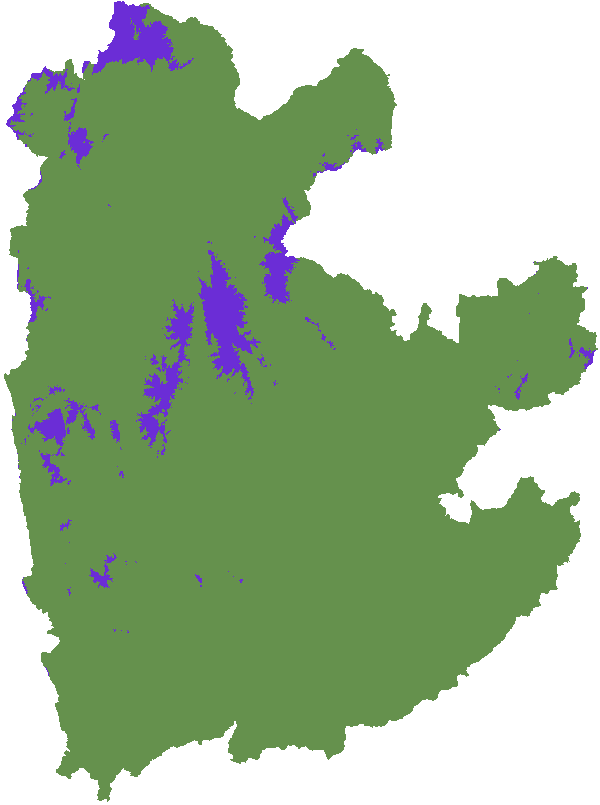

In [76]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

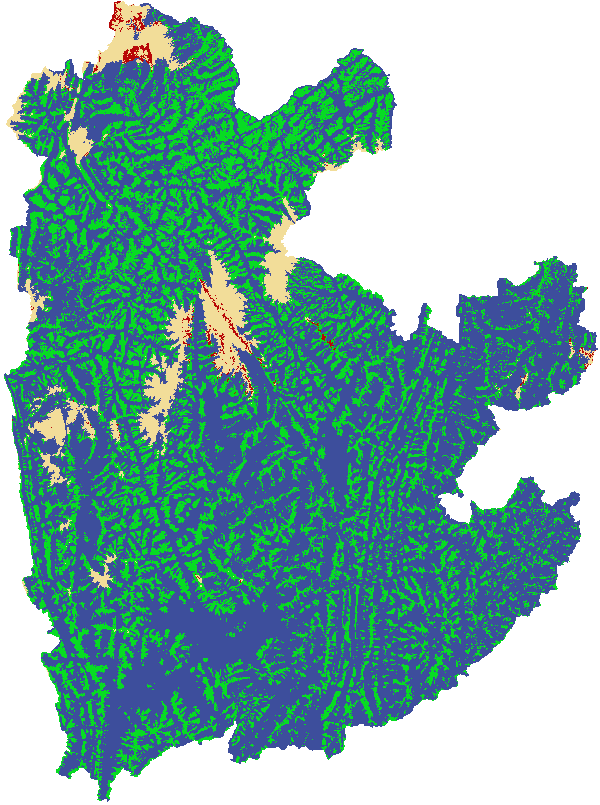

In [89]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

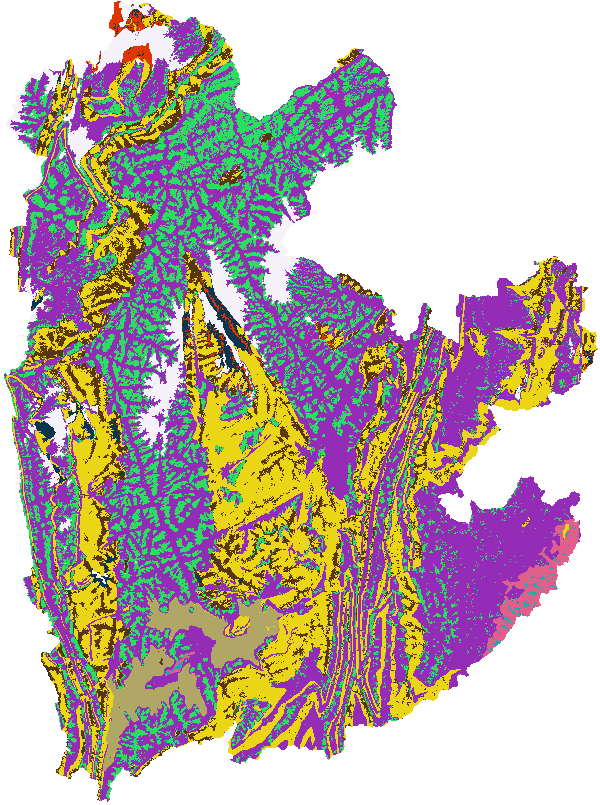

In [101]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

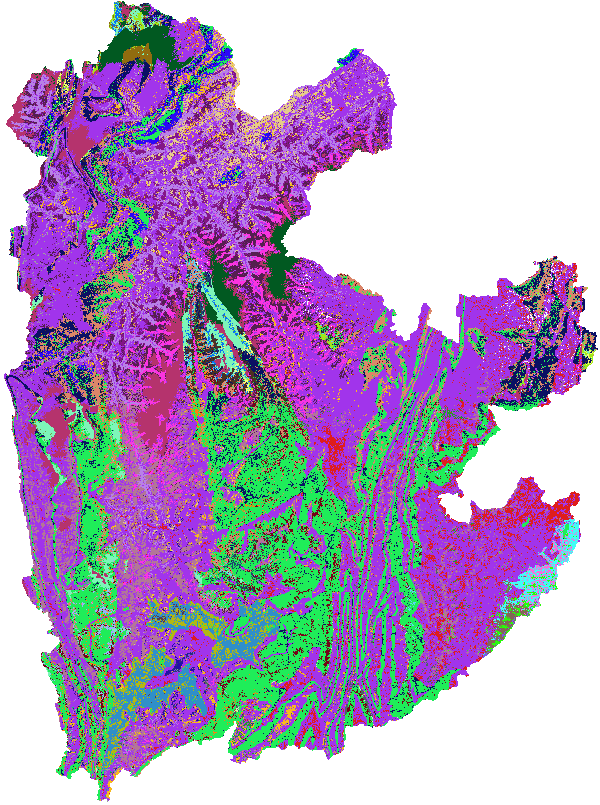

In [128]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

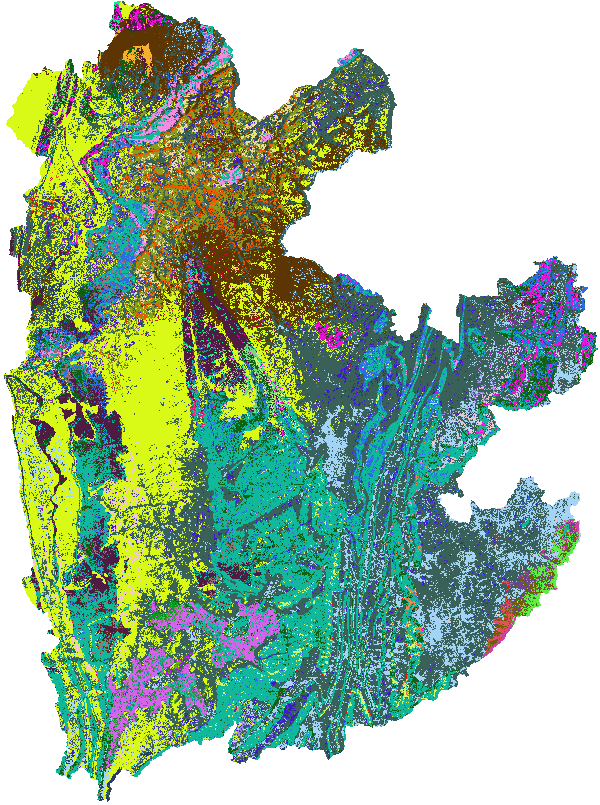

In [16]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred_index"))

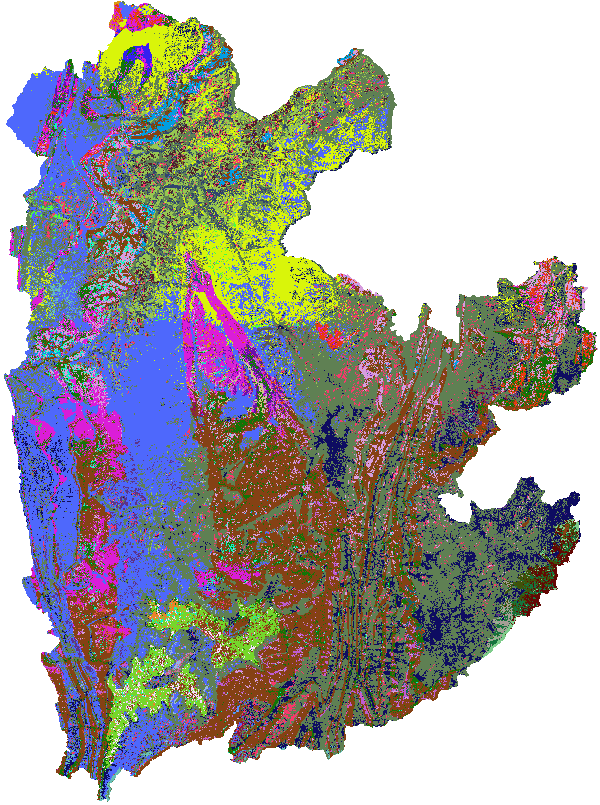

In [16]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred_index_2"))

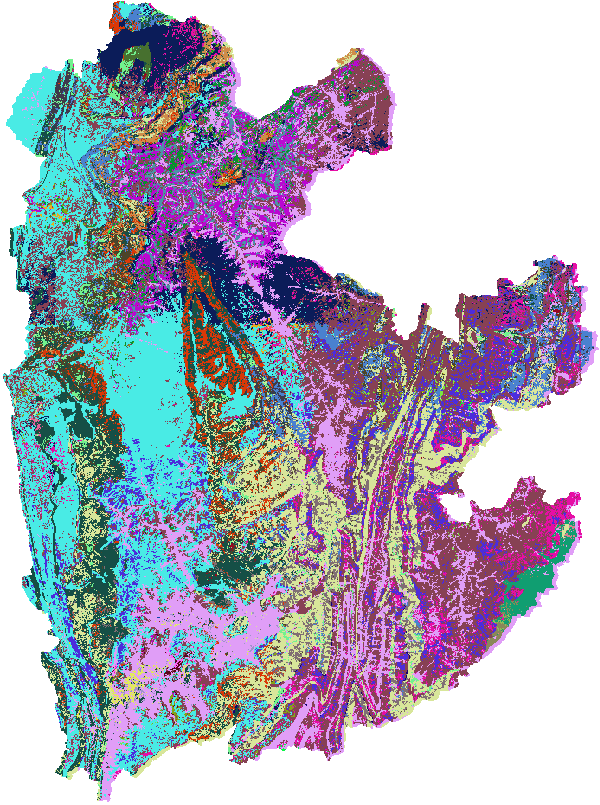

In [4]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,"TL_PRED_END_nibble"))

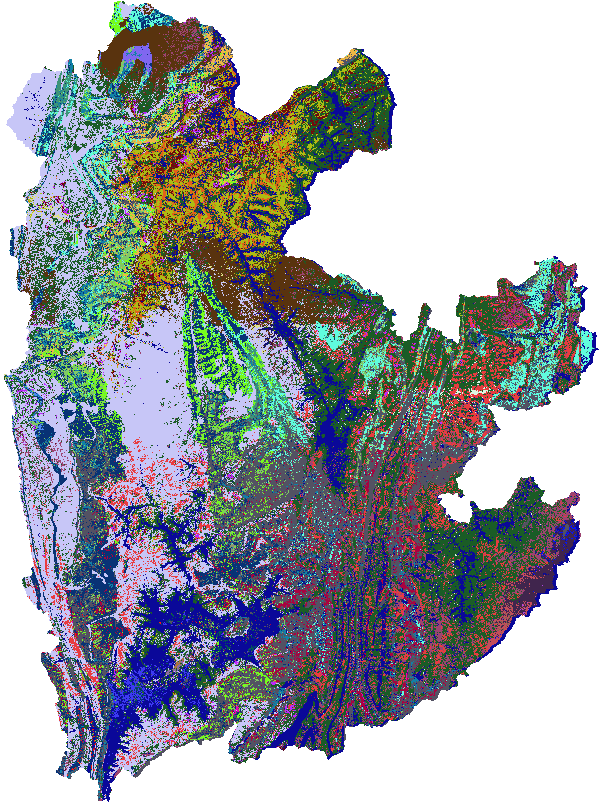

In [12]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}"))

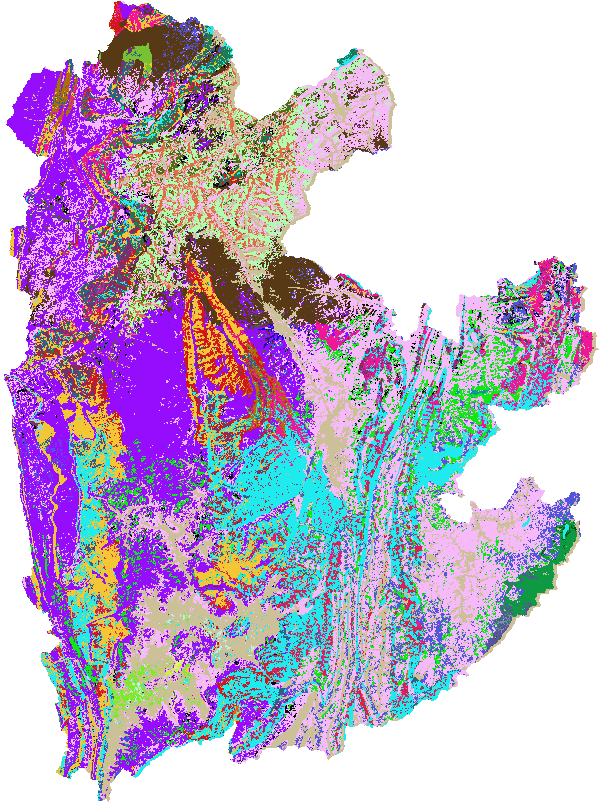

In [11]:
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_nibble"))